# Data set preprocessing
In this notebook, we will preprocess the dataset used to implement the algorithm. This is an image dataset for detection of blood cancer cells.
Since this data set does not provide Ground Truth, we use Segment Anything Model (SAM) to preprocess it and find ground truth to realize the encoding work of self-supervised learning

#1 Install SAM and load Library

##1.1 Install SAM (Segment anything model)

In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git  -q
!pip install opencv-python pycocotools matplotlib onnxruntime onnx  -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 87.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.6 MB/s eta 0:00:00


##1.2 Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

repo = "/content/drive/MyDrive/Dissertation/MyWork/Dataset/" #will be useful to loop over the files later on.

Mounted at /content/drive


##1.3 import library

In [3]:
import imageio.v2 as img
import matplotlib.pyplot as plt
import os
import sys

import numpy as np
# import pickle
# import gc
from PIL import Image
from segment_anything import SamPredictor, sam_model_registry
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import random

#2 Load and data preprocessing (Blood Cancer - Image Dataset)


this is a data set from https://www.kaggle.com/datasets/akhiljethwa/blood-cancer-image-dataset

Because of the gound truth of this data set is not available on kaggle, we will use SAM to segment the images, and then identify and label of the stained cells for self-supervised machine learning.

##2.2 load one images

### define 3 functions to use SAM model

select_sam: choose a model size

show_anns: visualization function

img_choose: image converter


In [4]:
 # choose model
 # 0:H 1:L 2:B
 # H is the largest model
def select_sam(model_id):
    b_checkpoint = "/content/drive/MyDrive/Dissertation/MyWork/SAM model/sam_vit_b_01ec64.pth"
    l_checkpoint = "/content/drive/MyDrive/Dissertation/MyWork/SAM model/sam_vit_l_0b3195.pth"
    h_checkpoint = "/content/drive/MyDrive/Dissertation/MyWork/SAM model/sam_vit_h_4b8939.pth"
    sam_checkpoint = [h_checkpoint,l_checkpoint,b_checkpoint]
    model_type = ["vit_h","vit_l","vit_b"]
    device = "cuda"

    sam = sam_model_registry[model_type[model_id]](checkpoint=sam_checkpoint[model_id])
    sam.to(device=device)
    create_mask_generator = SamAutomaticMaskGenerator(sam)
    return create_mask_generator


def show_anns(anns): #This function is defined by Meta in their demo.
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def img_choose(img_name):
    choose_img = img.imread(img_name)
    #to PIL format
    pil_image = Image.fromarray(choose_img)
    pil_image = pil_image.convert('RGB')
    # resize
    resized_image = pil_image.resize((1024, 1024))
    choose_img = np.array(resized_image)
    return choose_img

load 1 image for test

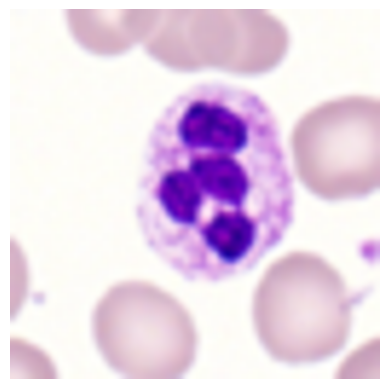

In [5]:
img_1 = img_choose(repo + "Blood_Cancer/Sample_331.tiff")
plt.axis('off')
plt.imshow(img_1)

##2.1 segment the image with SAM

In [6]:
# choose model
SAM_masker = select_sam(0)

In [7]:
# generate mask
masks_1 = SAM_masker.generate(img_1)

Then visualize it. We can see that the stained cells in the image have been identified, but some unobvious normal cells have not been identified

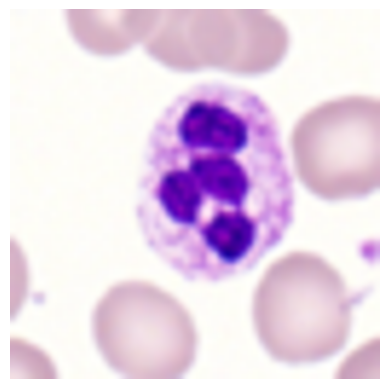

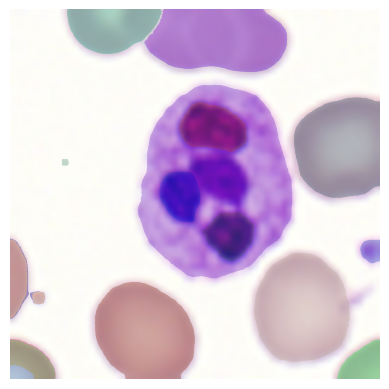

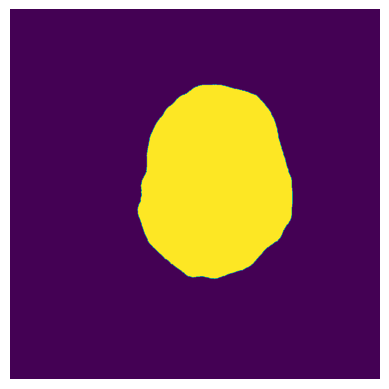

In [8]:
# plt.figure(figsize=(12,4))
# plt.subplot(1, 3, 1)
plt.axis('off')

plt.imshow(img_1)
plt.show()
# plt.subplot(1, 3, 2)
plt.axis('off')

plt.imshow(img_1)

show_anns(masks_1)
plt.show()
# plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(masks_1[1]['segmentation'])
plt.show()


##2.2 Attempt to algorithmically find stained cells

After the image is segmented with SAM, the next step is to find our ground truth from these segments. Since the color of the stained cells will change to purple, we can distinguish them by color contrast.
And due to the rgb color is not convenient for comparison and calculation, so
we can convert the original image into a grayscale image, which is convenient for comparing the colors in it.
The stained cells will change from pink to purple, and the nuclei are stained very deeply, so we can think that the ground truth of this picture is the overlapping part of all blocks containing the minimum gray value of the whole image

###2.2.1 Convert image to grayscale

In [6]:
def rgb_to_gray(rgb_image):
    # calculate gray value
    gray_image = np.dot(rgb_image[..., :3], [0.2989, 0.5870, 0.1140])
    return gray_image

In [ ]:
# turn img to gray
gray_img_1 = rgb_to_gray(img_1)

(-0.5, 1023.5, 1023.5, -0.5)

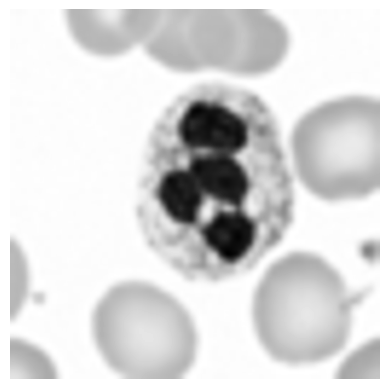

In [ ]:
plt.imshow(gray_img_1, cmap='gray')
plt.axis('off')

###2.2.2 Find the minimum value of the grayscale

In [7]:
# Calculate the minimum of each region's color
def calculate_gray_min(image_array, mask_array):

    masked_color_pixels = image_array[mask_array]
    gray_min = np.min(masked_color_pixels)

    return gray_min

In [ ]:
color_list = []
# iterate over all masks
for item in masks_1:
    # Save the minimum gray value in each segment to the list
    color_min = calculate_gray_min(gray_img_1, item['segmentation'])
    color_list.append(color_min)


In [ ]:
list_index = []
for index, item in enumerate(color_list):
    list_index.append(f"{index}: {item}")

# Sort the grayscale values to find the smallest grayscale
list_sorted = sorted(list_index, key=lambda x: float(x.split(': ')[1]))

In [ ]:
list_sorted

['1: 24.8714',
 '11: 24.8714',
 '15: 29.2409',
 '13: 35.6471',
 '12: 140.3492',
 '9: 171.90429999999998',
 '7: 175.491',
 '2: 176.6049',
 '3: 176.6049',
 '4: 176.7898',
 '0: 179.0176',
 '6: 179.0176',
 '8: 185.3113',
 '5: 185.963',
 '10: 187.5283',
 '16: 187.5283',
 '17: 195.7294',
 '14: 207.97599999999997',
 '18: 252.81759999999997']

###2.2.3 Generate ground truth

In [8]:
def segment_ground_truth(img):

    masks = SAM_masker.generate(img)
    gray_img_tmp = rgb_to_gray(img)
    gray_tmp = []
    # Save the minimum gray value in each segment to the list
    for item in masks:
        gray_min_value = calculate_gray_min(gray_img_tmp, item['segmentation'])
        gray_tmp.append(gray_min_value)
    # sort gray value
    gray_list_tmp = []
    for index, item in enumerate(gray_tmp):
        gray_list_tmp.append(f"{index}: {item}")
    stained_list = sorted(gray_list_tmp, key=lambda x: float(x.split(': ')[1]))
    # generate ground truth
    stained_mask = masks[int(stained_list[0].split(":", 1)[0])]['segmentation']

    return stained_mask

Test the effect with single image

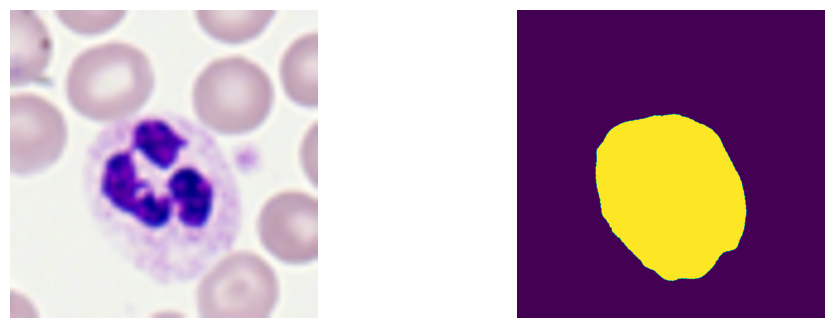

In [ ]:
#. 7621
# 5997
test_img = img_choose(repo + "Blood_Cancer/Sample_721.tiff")
test_ground = segment_ground_truth(test_img)
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(test_img)


plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(test_ground)

plt.show()

Test the effect with multiple images

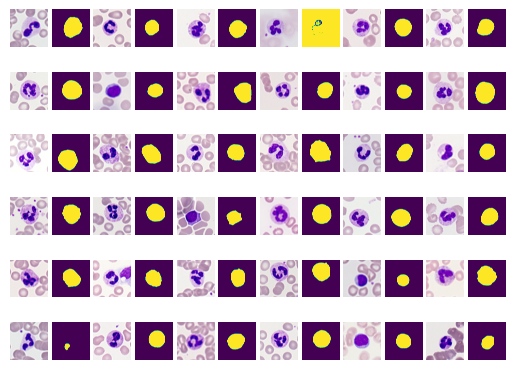

In [10]:
random_img = random.sample(range(1, 9000), 36)

for i, item in enumerate(random_img):
    # 取图片
    img_tmp = img_choose(repo + "Blood_Cancer/Sample_" + str(item) + ".tiff")
    stained_ground = segment_ground_truth(img_tmp)
    # plt.figure(figsize=(7,15))
    plt.subplot(6, 12, 2*i + 1)
    plt.imshow(img_tmp)
    plt.axis('off')
    plt.subplot(6, 12, 2*i + 2)
    plt.imshow(stained_ground)
    plt.axis('off')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

#3 Generate ground truth in batches

Batch process images to generate mask files, specify the start and end numbers, generate a list, and then generate ground truth in a loop

In [ ]:
def create_groun_truth(start_id, end_id):
    if start_id > end_id:
        start, end = end, start
    id_lsit = list(range(start_id, end_id + 1))

    for item in id_lsit:
        img_tmp = img_choose(repo + "Blood_Cancer/Sample_" + str(item) + ".tiff")
        stained_ground = segment_ground_truth(img_tmp)

        # 将NumPy数组转换为PIL图像对象
        groun_truth = Image.fromarray(stained_ground)

        # 将PIL图像保存为PNG格式文件
        img_name = "Sample_" + str(item) + "_gt.png"
        groun_truth.save(repo + "GT1024/" + img_name)
        print(str(item) + "saved!")


In [ ]:
create_groun_truth(5001,10000)

test the results

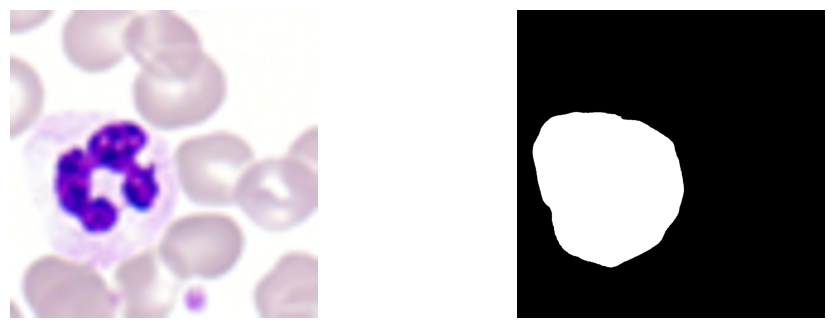

In [ ]:
imd_test_id = '2'
img_test = img_choose(repo + "Blood_Cancer/Sample_" + imd_test_id + ".tiff")
img_gt = img_choose(repo + "GT1024/Sample_" + imd_test_id + "_gt.png")

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(img_test)


plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(img_gt)

plt.show()